# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

<i>In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.</i>

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# magic word for producing visualizations in notebook
%matplotlib inline

pd.set_option('display.max_colwidth', None)

## Part 0: Get to Know the Data

<i>There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.</i>

### Data Import

For the first portion of this analysis we'll import the data for the population and customer datasets. The values and attributes files contain useful information, but are not in the best formats for use with pandas. These will need to go through some additional cleaning steps, but will be useful to import as a dataframe for comparing the information to the actual datasets.

In [2]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')
values_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
attributes_df = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)

C:\Users\arshl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


A warning appears for columns 18 and 19 stating that they have multiple value types. Let's take a note of these column names address this issue in a later step.

In [3]:
# print names of columns 18 and 19

col_18 = azdias.columns[18]
print('Azdias Column 18 name: ', col_18)
col_18 = customers.columns[18]
print('Customers Column 18 name: ', col_18)

col_19 = azdias.columns[19]
print('Azdias Column 19 name: ', col_19)
col_19 = customers.columns[19]
print('Customers Column 19 name: ', col_19)

Azdias Column 18 name:  CAMEO_DEUG_2015
Customers Column 18 name:  CAMEO_DEUG_2015
Azdias Column 19 name:  CAMEO_INTL_2015
Customers Column 19 name:  CAMEO_INTL_2015


Before diving deep into cleaning the data, we can check the datasets to ensure they imported as expected. This includes checking the columns between each set. The instructions state we should expect to see 3 columns in the customers dataset that are not present in the population dataset: `'CUSTOMER_GROUP', 'ONLINE_PURCHASE',` and `'PRODUCT_GROUP'`. A function is used to take in two dataframes and return any unmatched columns.

In [4]:
# check structure of each dataframe

print('Population dataset:')
print(azdias.shape)

print('Customer dataset:')
print(customers.shape)

Population dataset:
(891221, 366)
Customer dataset:
(191652, 369)


In [5]:
def column_check(df1, df2):
    '''
    Parameters
    ----------
    df1 : DataFrame
        First dataframe to compare columns across.
    df2 : DataFrame
        Second dataframe to compare columns across.

    Returns
    -------
    List
        Prints a list of columns that do not match between the dataframes.
    '''
    unmatched_cols1 = list(set(df1.columns) - set(df2.columns))
    unmatched_cols2 = list(set(df2.columns) - set(df1.columns))
    print('The following columns do not match:')
    print('First data frame: ', unmatched_cols1)
    print('Second data frame: ', unmatched_cols2)
    return unmatched_cols1, unmatched_cols2

In [6]:
column_check(customers, azdias)

The following columns do not match:
First data frame:  ['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE']
Second data frame:  []


(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'], [])

The structures of the dataframes and the unmatched columns that were found are as expected. The `customers` data contains the three additional columns, and all columns in the `azdias` data are also within the `customers` data.

The extra columns can remain in the customers data for now. They will be removed in a later step.

### Value Reference Data

The value file information is not in a format that easily imports into a pandas data frame. Therefore some cleaning is needed to make that data easily used for further clean the other datasets.

The below functions clean up the values dataframe and produce two additional frames for doubled values, categories that have two possible numeric values, and unique values that contains all the possible unique values for each field.

In [7]:
# function to be applied to the values dataframe

def split_double_values(element):
    '''
    Parameters
    ----------
    element : STR
        String to be split and first value retrieved

    Returns
    -------
    element : STR
        Returns first value of the split string object
    '''
    if ',' in element:
        element = element.split(', ')
        element = element[0]
    return element

# cleaning function for values dataframe

def clean_values_df(values_df):
    '''
    Parameters
    ----------
    values_df : DataFrame
        Dataframe containing information from DIAS Attributes - Values 2017.xlsx

    Returns
    -------
    doubled_values : DataFrame containing doubled values and corresponding attribute.
    unique_values : DataFrame containing unique values for each attribute.
        Cleans values_df to remove an unnamed column and forward fill the attribute information to other rows.
        Sets value column to first value if double values exist.
    '''
    values_df.drop('Unnamed: 0', axis=1, inplace=True) # first column contains no data
    values_df.loc[:,'Attribute'] = values_df.loc[:,'Attribute'].ffill() # only the first value for each attribute is filled in
    doubled_values = values_df.loc[values_df['Value'].astype(str).str.contains(',')] # doubled values are separated by ','
    values_df['Value'] = values_df['Value'].astype(str)
    values_df['Value'] = values_df['Value'].apply(split_double_values)
    values_df = values_df.loc[values_df['Value'] != '…'] # some columns are continuous and don't have distinct values listed
    unique_values = pd.DataFrame(values_df.groupby('Attribute')['Value'].unique())
    unique_values['Value'] = unique_values['Value'].apply(lambda x: tuple(x))
    unique_values = unique_values.reset_index()
    return doubled_values, unique_values

In [8]:
doubled_values, unique_values = clean_values_df(values_df)

The doubled values can be examined to see how many unique values have more than one possible numeric value. Once identified, these can be corrected in the main datasets so only one of the values is used.

In [9]:
doubled_values['Value'].unique()

array(['-1, 0', '-1, 9'], dtype=object)

In [10]:
# function to correct other "doubled" values to single value

def correct_double_values(df, doubled_values=doubled_values):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataframe to check double values for. This will convert any 
        columns with more than one possible value for the same category to a single value.
    doubled_values : DataFrame
        Contains information on attributes that have multiple values for a single category.

    Returns
    -------
    df : DataFrame 
        Dataframe with corrected double values.
    '''
    first_group = list(doubled_values.loc[doubled_values['Value'] == '-1, 0','Attribute'])
    second_group = list(doubled_values.loc[doubled_values['Value'] == '-1, 9','Attribute'])
    for c in first_group:
        if c in df.columns:
            df.loc[df[c]==0.0, c] = -1
    for c in second_group:
        if c in df.columns:
            df.loc[df[c]==9.0, c] = -1 
    return df

In [11]:
customers_clean = correct_double_values(customers)
azdias_clean = correct_double_values(azdias)

Only two combinations of multiple values with the same meaning were possible with '0' or '9' being the other values. The '-1' which was similar between the groups was used as the base value. Any '0' or '9' values in the matching columns were changed to '-1'.

Next the unknown values can be standardized to 'nan' values instead of '-1' or other values. To do this we'll use the values dataframe to check which value for each column represents 'unknown', then simply change those values to 'nan'.

In [12]:
# unknown values
unknown_values = values_df.loc[values_df['Meaning'].str.contains('unknown', na=False),]

# function to set all unknown values to 'nan'
def standardize_unknowns(df, unknown_values = unknown_values):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataframe to standardize the unknown values on.
    unknown_values : DataFrame
        Dataframe containing all values that correspond to 'unknown' meaning.

    Returns
    -------
    df : DataFrame
        Input dataframe corrected with unknown values replaced to np.nan
    '''
    for i, row in unknown_values.iterrows():
        col = row[0]
        if col == 'CAMEO_DEUINTL_2015': # a column in the values list has a slightly different name than the same from the datasets
            col = 'CAMEO_INTL_2015'
        val = int(row[2])
        if col in df.columns:
            df[col] = df[col].replace(val, np.nan)
    return df

In [13]:
customers_clean = standardize_unknowns(customers_clean)
azdias_clean = standardize_unknowns(azdias_clean)

### Mismatched Column Types (18 & 19)

With a lot of the initial cleaning out of the way, the problem with colunmns 18 & 19 can be addressed. The issue with these columns was multiple dtypes. Unique values for these can indicate what's going on.

Running the unique values for the same columns from the values dataframe should point out any discrepancies and ensure only valid values are in the datasets.

In [14]:
print(customers_clean[col_18].unique())
print(azdias_clean[col_18].unique())
print(customers_clean[col_19].unique())
print(azdias_clean[col_19].unique())

[1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X']
[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
[13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43'
 '22' '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33'
 'XX']
[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']


In [11]:
print(unique_values.loc[unique_values['Attribute']==col_18,'Value'].unique())
print(unique_values.loc[unique_values['Attribute']=='CAMEO_DEUINTL_2015','Value'].unique())

[('-1', '1', '2', '3', '4', '5', '6', '7', '8', '9')]
[('-1', '11', '12', '13', '14', '15', '21', '22', '23', '24', '25', '31', '32', '33', '34', '35', '41', '42', '43', '44', '45', '51', '52', '53', '54', '55')]


Comparing the values from the datasets to the values list, 'X' and 'XX' stand out as a mis-matched values and need to be cleaned. Regarding the dtypes, the columns are mismatched with strings, floats, and integers but looks like it should only be integer format.

The next function replaces the 'X' and 'XX' values and sets the columns as float type. Float is needed instead of integer due to the 'nan' values.

In [15]:
def clean_col_1819(df):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataframe which contains col_18 and col_19 to correct certain values.

    Returns
    -------
    df : DataFrame
        Input dataframe with col_18 and col_19 corrected.
    '''
    col_18=df.columns[18]
    col_19=df.columns[19]
    df[col_18] = df[col_18].replace('X',np.nan)
    df[col_19] = df[col_19].replace('XX',np.nan)
    df[col_19] = df[col_18].astype(float)
    df[col_19] = df[col_19].astype(float)
    return df

In [16]:
customers_clean = clean_col_1819(customers_clean)
azdias_clean = clean_col_1819(azdias_clean)

### Missing Data

The next step of the data preparation process is to check and handle missing data.

Firstly, a plot of the proportion of missing values for each column can give an idea of how many missing values exist at the column level. From there, a threshold can be set to determine which columns can be dropped entirely due to a high proportion of missing values.

In [17]:
# function to plot missing value percentages for a list of dataframes

def plot_missing_percentages(df_list):
    '''
    Parameters
    ----------
    df_list : List of DataFrame objects
        Dataframe to plot and compare missing value proportions.

    Returns
    -------
    None.
        Produces plot of missing data proportions for each object in df_list.
    '''
    i = 0
    fig = plt.figure(figsize=(10,70))
    fig.suptitle("Missing Data percentages")
    for df in df_list:
        missing_vals = df.isnull().sum()/len(df)*100
        missing_vals = missing_vals[missing_vals > 0].sort_values(ascending=False)
        ax = fig.add_subplot(121+i)
        sns.barplot(x = missing_vals.values, y = missing_vals.index,ax=ax)
        for p in ax.patches:
            width = p.get_width()
            ax.text(width + 1,
                    p.get_y() + p.get_height() / 2,
                    '{:1.2f}'.format(width),
                    ha = 'left',
                    va = 'center')
        i += 1
    fig.tight_layout(rect=[0, 0.03, 1.50, 0.975])
    plt.show()
    return

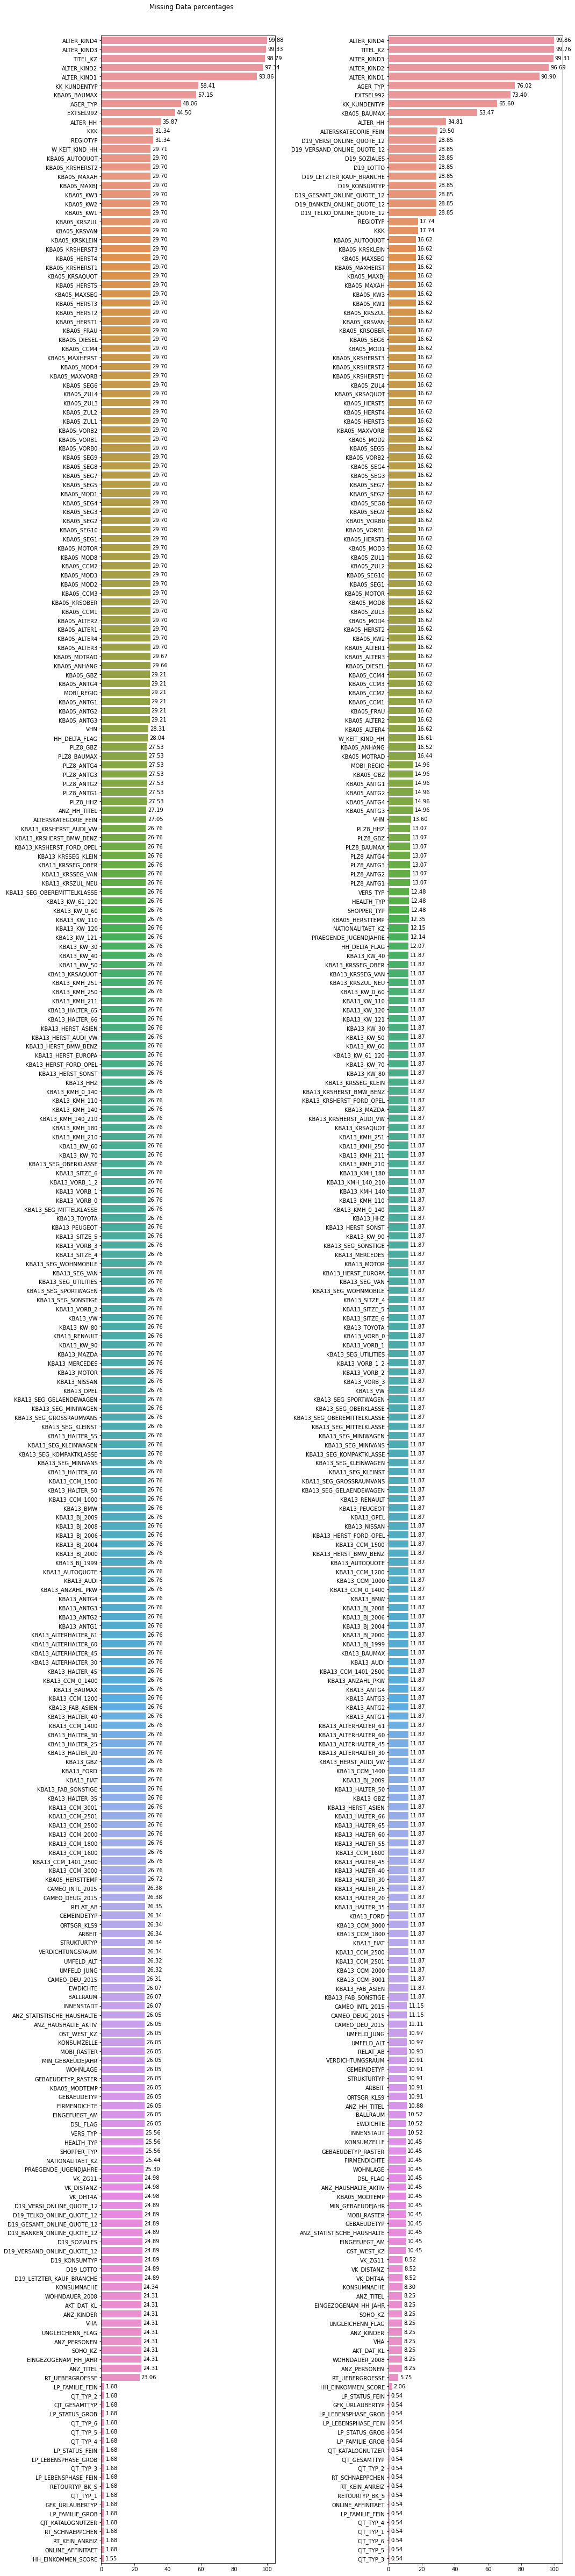

In [18]:
plot_missing_percentages([customers_clean,azdias_clean])

The plots show most columns containing < 30% missing values, then ramping up quickly to a peak of almost 100% for `ALTER_KIND4` in both datasets. The 30% mark appears to be a reasonable threshold by which to remove columns. This would result in 12 columns removed from the customers data, and 10 for the population data.

The function below will remove columns with over a specified percentage of missing values:

In [19]:
def drop_missing_by_column(df, percentage):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataframe to drop columns from that meet specified percentage of null values.
    percentage : Float
        Percentage to use as cutoff for dropping columns.

    Returns
    -------
    df : DataFrame
        Input dataframe with columns >= percentage of nulls dropped.
    '''
    drop_cols = []
    for c in df.columns:
        if df[c].isnull().sum() / len(df) >= percentage:
            drop_cols.append(c)
    print('Dropping columns: ', drop_cols)
    df = df.drop(drop_cols, axis=1)
    return df

In [20]:
customers_clean = drop_missing_by_column(customers_clean, 0.30)
azdias_clean = drop_missing_by_column(azdias_clean, 0.30)

Dropping columns:  ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'KKK', 'REGIOTYP', 'TITEL_KZ']
Dropping columns:  ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


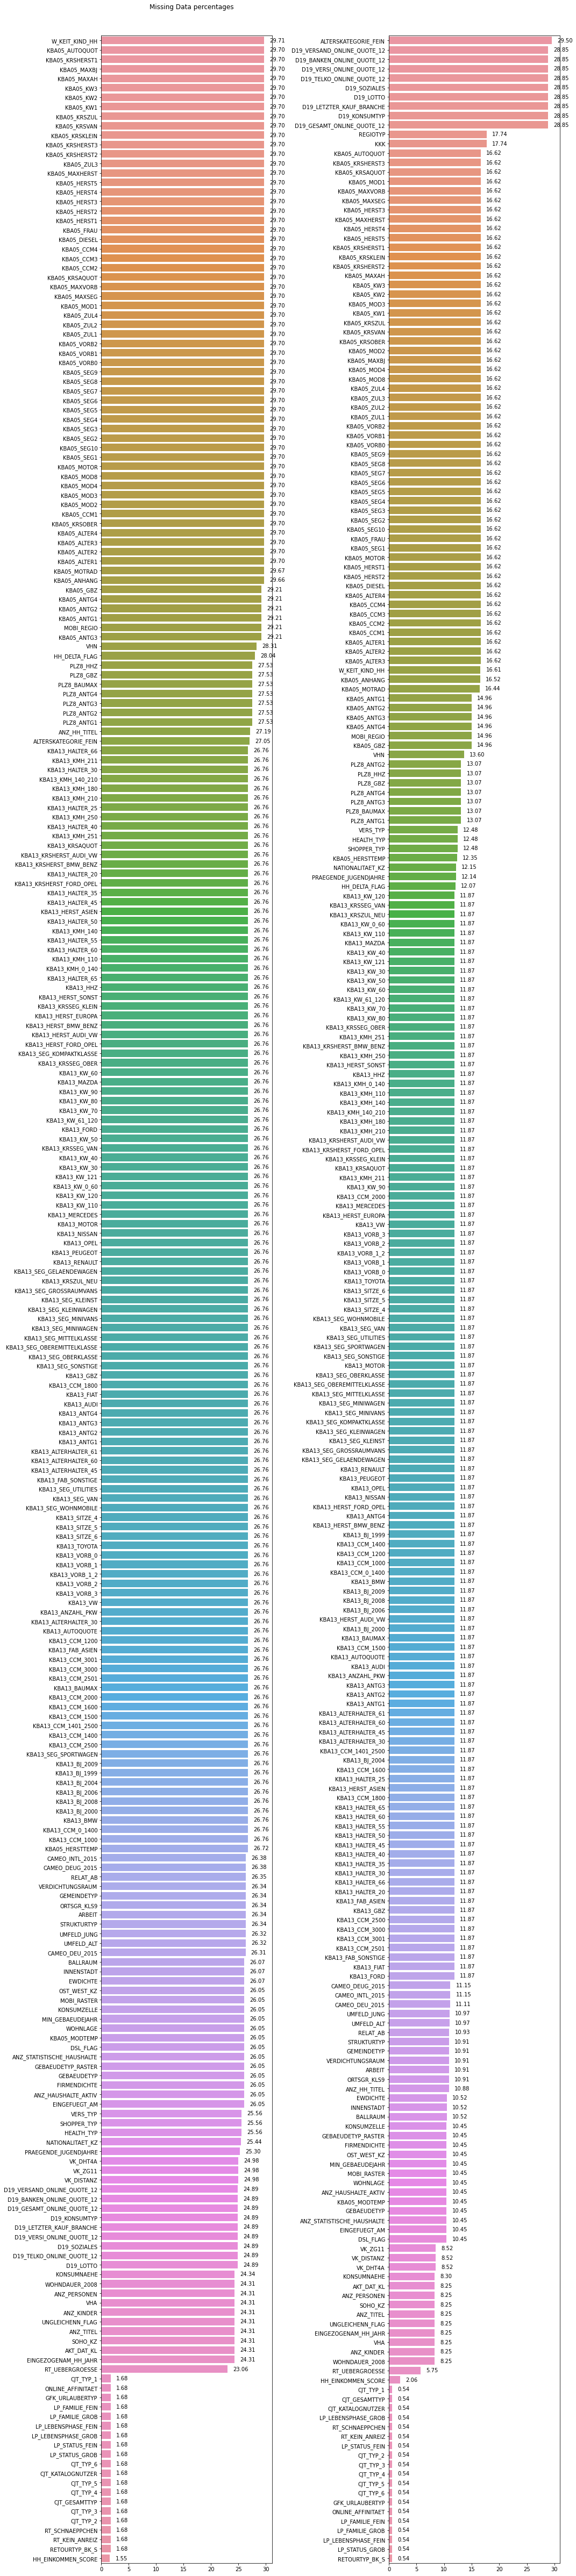

In [15]:
plot_missing_percentages([customers_clean,azdias_clean])

As a check, the `column_check` function can be used again to find any mis-matches between the datasets.

In [21]:
customers_unmatched, azdias_unmatched = column_check(customers_clean, azdias_clean)

The following columns do not match:
First data frame:  ['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE']
Second data frame:  ['KKK', 'REGIOTYP']


As expected, the population dataframe contains 2 additional columns that were dropped from customers. These can be dropped directly.

In [17]:
azdias_clean.drop(azdias_unmatched, axis=1, inplace=True)

Re-running the plot confirms that missing values by column are now all < 30%. For the next step we can check missing values by row to eliminate entries with a high proportion of missing values.

In [22]:
def plot_missing_by_row(df_list):
    '''
    Parameters
    ----------
    df_list : List of DataFrame objects
        Dataframe to plot and compare missing value proportions.

    Returns
    -------
    None.
        Produces historgram of missing data by row for each object in df_list.
    '''
    fig = plt.figure(figsize=(7,7))
    fig.suptitle('Missing Data by Row')
    for df in df_list:
        sns.distplot(df.isnull().sum(axis=1))
    plt.show()
    return

C:\Users\arshl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\arshl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


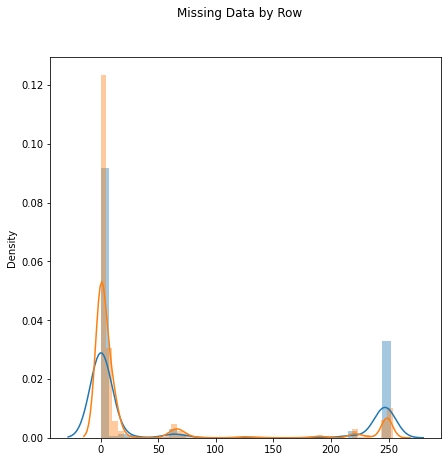

In [23]:
plot_missing_by_row([customers_clean,azdias_clean])

A distribution plot of missing values by row shows that most rows have less than 50 missing values, with another small peak just over 50. There's a noteable collection of rows in each dataset that have > than 200 missing values. Since there's a clear break at >50 and <50, we can use 50 as the threshold. The following function removes those rows.

In [24]:
def remove_missing_rows(df, threshold):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataframe to remove rows with missing values meeting the threshold.
    threshold : Int
        Number of missing values a row must meet in order to be removed.

    Returns
    -------
    df : DataFrame
        Input dataframe with rows containing missing values over the threshold removed.
    '''
    df = df.loc[df.isnull().sum(axis=1) < threshold,]
    return df

In [25]:
threshold = 50

customers_clean = remove_missing_rows(customers_clean, threshold)
azdias_clean = remove_missing_rows(azdias_clean, threshold)

C:\Users\arshl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\arshl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


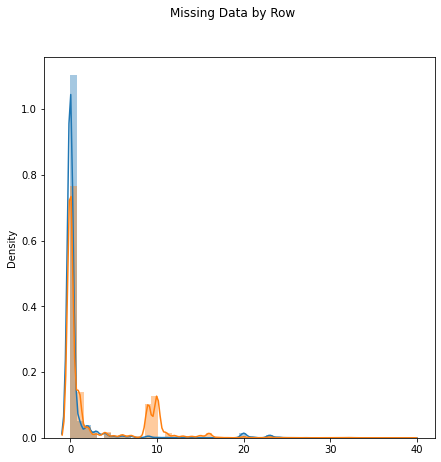

In [20]:
plot_missing_by_row([customers_clean,azdias_clean])

Although most of the missing values have been dealt with at this point, there's still many missing values throughout the dataset that would be best to minimize. One strategy is to inpute missing values. Since much of the data in these sets is categorical, a good approach is to impute missing values using the mode of each column. The next function finds any columns with at least 1 'nan' value and replaces them with the column's mode.

In [26]:
def impute_missing_values(df):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataframe to impute missing values for by the mode of each column.

    Returns
    -------
    df : DataFrame
        Input dataframe with missing values replaced by the column's mode.
    '''
    for c in df.columns:
        nas = df[c].isnull().sum()
        if nas > 0:
            df[c] = df[c].fillna(df[c].mode()[0])
    return df

In [27]:
customers_clean = impute_missing_values(customers_clean)
azdias_clean = impute_missing_values(azdias_clean)

The data is now mostly cleaned and ready for additional analysis. However, in anticipation of the segmentation portion and use of the K-Means classification method it's best to ensure our data is numeric. Having numeric data will allow for scaling and dimension reduction via principal component analysis (PCA) or other techniques.

The following function identifies any 'object' dtype columns, meaning there are strings or other non-numeric datatypes present in the column. It will also print the unique values for each column found.

In [28]:
def get_object_columns(df):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataframe to check for object column dtypes on.

    Returns
    -------
    None.
        Prints list of columns in df with object dtype.
    '''
    object_cols = df.columns[df.dtypes=='object']
    print('\n', len(object_cols), ' object columns found.')
    for c in object_cols:
        print(c)
        print(df[c].unique())

In [29]:
get_object_columns(customers_clean)
get_object_columns(azdias_clean)


 7  object columns found.
CAMEO_DEU_2015
['1A' '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '9D' '8B' '6B' '9C' '5C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '1E' '2C' '7C' '5A'
 '2B' '6D' '7A' '7E' '5E' '6E' '9A' '4B' '1C' '1B' '6A' '8D' '7D' '6F'
 '3A' '4D' 'XX']
CAMEO_DEUG_2015
[1.0 5.0 4.0 7.0 3.0 9.0 2.0 8.0 6.0 '2' '6' '3' '8' '9' '4' '1' '7' '5']
D19_LETZTER_KAUF_BRANCHE
['D19_UNBEKANNT' 'D19_NAHRUNGSERGAENZUNG' 'D19_SCHUHE' 'D19_BUCH_CD'
 'D19_DROGERIEARTIKEL' 'D19_SONSTIGE' 'D19_TECHNIK' 'D19_VERSICHERUNGEN'
 'D19_BANKEN_GROSS' 'D19_VOLLSORTIMENT' 'D19_HAUS_DEKO' 'D19_ENERGIE'
 'D19_REISEN' 'D19_BANKEN_LOKAL' 'D19_VERSAND_REST' 'D19_FREIZEIT'
 'D19_BEKLEIDUNG_GEH' 'D19_TELKO_REST' 'D19_SAMMELARTIKEL'
 'D19_BANKEN_DIREKT' 'D19_KINDERARTIKEL' 'D19_TELKO_MOBILE'
 'D19_BEKLEIDUNG_REST' 'D19_BANKEN_REST' 'D19_LEBENSMITTEL' 'D19_GARTEN'
 'D19_HANDWERK' 'D19_RATGEBER' 'D19_DIGIT_SERV' 'D19_BIO_OEKO'
 'D19_BILDUNG' 'D19_WEIN_FEINKOST' 'D19_TIERARTIKEL' 'D19_LOTTO'
 'D19_KOSMETIK

In the customers dataset, 7 columns are 'object' dtype and in the population dataset, only 5 were found. Except for `PRODUCT_GROUP` and `CUSTOMER_GROUP` in the customers dataset, the other columns are common between the two datasets. Note that these 2 columns are part of the 3 additional columns the customers dataset was said to contain. These can be ignored for now as they are removed later prior to segmentation analysis.

Examining the remaining object columns reveals a few patterns. The description for each column can be found in the values file as well.

- `CAMEO_DEU_2015` contains string values. Description: 'CAMEO classification 2015 - detailled classification'
- `CAMEO_DEUG_2015` is meant to be integers but is currently float and string values. Description: 'CAMEO classification 2015 - Uppergroup'
- `D19_LETZTER_KAUF_BRANCHE` is all string values. Not in values sheet.
- `EINGEFUEGT_AM` is date values held as strings. Not in values sheet.
- `OST_WEST_KZ` contains only 2 values, held as strings. Description: 'flag indicating the former GDR/FRG'

`CAMEO_DEU_2015` and `CAMEO_DEUG_2015` appear related with 'DEU' version being a more detailed breakdown of the 'DEUG' column. This may duplicate meaning and therefore one can be dropped. Using only the `CAMEO_DEUG_2015` column lowers the amount of possible values, and is already meant for numeric format.

`D19_LETZTER_KAUF_BRANCHE` and `EINGEFUEGT_AM` are not present in the values sheet. Therefore, their data would not have clear meaning and can be dropped.

`OST_WEST_KZ` only has 2 possible values, which can be encoded into numeric values.

The following function cleans the columns from an input dataframe as described above.

In [30]:
def clean_object_columns(df):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataframe to clean the object columns on.

    Returns
    -------
    df : DataFrame
        Input dataframe with object columns cleaned.
    '''
    df.drop(['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM'], axis=1, inplace=True)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(int)
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W':1,'O':0})
    return df

In [31]:
customers_clean = clean_object_columns(customers_clean)
azdias_clean = clean_object_columns(azdias_clean)

The object columns have been cleaned, but the extra columns present in the customers dataset still need to be handled. For the segmentation portion of this analysis these columns are not needed, though they may be helpful for the supervised learning portion.

A separate dataset can be created without these columns for the segmentation. Additionally, the `LNR` column is simply a unique indicator for each respondent. This column can be dropped as well in both datasets as it does not contribute meaningful data.

In [32]:
def drop_other_cols(df):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataframe to drop columns on.

    Returns
    -------
    df : DataFrame
        Input dataframe with specified columns dropped.
    '''
    cols = ['LNR','PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE']
    for c in cols:
        if c in df.columns:
            df = df.drop(c, axis=1)
    return df

In [33]:
customers_segmentation = drop_other_cols(customers_clean)
azdias_segmentation = drop_other_cols(azdias_clean)

The two datasets are cleaned and ready for the segmentation portion of the analysis. This same cleaning process will also need to be applied to the `mailout_train` and `mailout_test` datasets to prepare them for the supervised learning analysis. This will be completed in that section. 

## Part 1: Customer Segmentation Report

<i>The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.</i>

### Feature Scaling

The next portion of the analysis is to perform segmentation as a way to compare the population to the company's customers. A good choice of classification method to use is k-means clustering. Before that is possible though, the data needs to be scaled as the input features vary significantly in their raw values. For this analysis we'll employ the `StandardScaler` function to produce standardized versions of the customers and population datasets.

In [25]:
# set up scalers
azdias_scaler = StandardScaler().fit(azdias_segmentation)
customer_scaler = StandardScaler().fit(customers_segmentation)

# transform to both population and customers data
scaled_azdias = pd.DataFrame(azdias_scaler.transform(azdias_segmentation), columns = azdias_segmentation.columns)
scaled_customers = pd.DataFrame(customer_scaler.transform(customers_segmentation), columns = customers_segmentation.columns)

# confirm scaling
scaled_azdias.describe()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,...,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05
mean,-4.291587e-17,2.059962e-18,-5.416060e-17,-2.349380e-18,-2.103631e-18,7.440317e-17,8.242859e-19,2.967512e-17,1.606873e-16,-5.459531e-17,...,2.199497e-16,-1.023307e-16,6.850457e-17,-8.592329e-17,4.277131e-17,-7.629207e-17,-1.966682e-16,1.315123e-16,-1.395985e-16,2.037724e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-9.343305e-01,-3.092781e+00,-5.411578e-01,-1.253032e-01,-2.990606e-01,-1.493626e+00,-5.459847e-01,-6.066049e-02,-2.191531e+00,-1.438010e+00,...,-2.085931e+00,-1.757682e+00,-2.005059e+00,-1.764638e+00,-1.880919e+00,-3.687897e+00,-2.137631e+00,-1.700552e+00,-1.043354e+00,-1.682098e+00
25%,-9.343305e-01,-4.336108e-01,-4.087995e-01,-1.253032e-01,-2.990606e-01,-6.344686e-01,-4.725354e-01,-6.066049e-02,-1.832950e-01,-9.804868e-01,...,-3.550451e-01,-7.065554e-01,-7.770725e-01,-6.914679e-01,-7.477219e-01,1.836032e-02,-5.558140e-01,-2.796640e-01,-1.043354e+00,-7.570360e-01
50%,-3.851852e-01,2.311817e-01,-2.764413e-01,-1.253032e-01,-2.990606e-01,-6.344686e-01,-2.521876e-01,-6.066049e-02,-1.832950e-01,3.920834e-01,...,-3.550451e-01,-5.804362e-03,1.439177e-01,2.397897e-02,3.854755e-01,5.478257e-01,-5.558140e-01,-2.796640e-01,9.584476e-01,1.680257e-01
75%,1.262251e+00,4.527792e-01,5.445438e-02,-1.253032e-01,-2.990606e-01,2.246884e-01,1.150588e-01,-6.066049e-02,8.208229e-01,8.496068e-01,...,5.103977e-01,1.045322e+00,7.579112e-01,7.394258e-01,9.520742e-01,5.478257e-01,4.987306e-01,4.307802e-01,9.584476e-01,1.093087e+00
max,1.262251e+00,2.447157e+00,3.493086e+01,6.412658e+01,2.221388e+01,3.115434e+01,2.699749e+01,5.855565e+01,5.841413e+00,1.307130e+00,...,1.375841e+00,1.746073e+00,1.678901e+00,1.812596e+00,9.520742e-01,5.478257e-01,2.080548e+00,1.851669e+00,9.584476e-01,5.718396e+00


In [26]:
# confirm scaling
scaled_customers.describe()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,...,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05
mean,2.445293e-17,1.578854e-16,5.054663e-18,-2.805206e-17,6.930975e-17,5.623644e-17,-5.610411e-18,-5.663340e-17,-2.265336e-17,-1.603731e-16,...,4.459219e-17,1.368729e-16,-1.247523e-16,4.636529e-17,1.641310e-16,3.403297e-17,7.886333e-17,4.694750e-17,1.223176e-16,7.280303e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-3.678580e-01,-2.543841e+00,-3.477195e-01,-1.249603e-01,-2.653181e-01,-1.636359e+00,-3.318417e-01,-1.347255e-01,-1.814141e+00,-1.557799e+00,...,-2.124037e+00,-1.134904e+00,-1.209336e+00,-9.496287e-01,-1.818370e+00,-7.381633e+00,-1.804932e+00,-1.073113e+00,-6.995274e-01,-3.314552e+00
25%,-3.678580e-01,-3.091892e-01,-2.748025e-01,-1.249603e-01,-2.653181e-01,-9.218211e-01,-2.578658e-01,-1.347255e-01,-8.228227e-01,-1.085161e+00,...,-3.703925e-01,-7.936636e-01,-8.621859e-01,-9.496287e-01,-1.281187e+00,2.739039e-01,-8.367601e-01,-1.073113e+00,-6.995274e-01,-6.707328e-01
50%,-3.678580e-01,-6.089456e-02,-2.748025e-01,-1.249603e-01,-2.653181e-01,-2.072833e-01,-2.578658e-01,-1.347255e-01,1.684960e-01,3.327544e-01,...,-3.703925e-01,-1.111829e-01,-1.678860e-01,-4.960028e-01,8.675453e-01,2.739039e-01,-3.526740e-01,4.624907e-01,-6.995274e-01,6.511768e-01
75%,-3.678580e-01,6.839892e-01,-5.605137e-02,-1.249603e-01,-2.653181e-01,5.072544e-01,-1.099141e-01,-1.347255e-01,1.159815e+00,8.053929e-01,...,5.064298e-01,9.125382e-01,5.264140e-01,4.112491e-01,8.675453e-01,2.739039e-01,6.154982e-01,4.624907e-01,1.429537e+00,6.511768e-01
max,3.818379e+00,3.663524e+00,3.778789e+01,3.939311e+01,1.665932e+01,1.336893e+01,2.740911e+01,3.247682e+01,6.116408e+00,1.278031e+00,...,1.383252e+00,2.277500e+00,2.956464e+00,3.586631e+00,8.675453e-01,2.739039e-01,2.067757e+00,2.765896e+00,1.429537e+00,7.260725e+00


Examining the datasets confirms the scaling was applied. Each of the features are now standardized with a standard deviation of 1.0.

### Dimensionality Reduction (Principal Component Analysis)

As they are, the datasets have over 300 features available for the analysis. Many of these features are possibly correlated in some way. Some of the features are even lower or higher level details of others.

Dimension reduction can be used to reduce the number of features to a manageable size and ensure these relationships can be addressed in the analysis. This reduction will employ Principal Component Analysis (PCA).

There's no single rule to deciding how many components to retain from a PCA output. One technique called the Kaiser rule is to examine the eigenvalues and retain any components with a value >= 1. We'll start with reducing the population dataset to 100 components, then select the features meeting the >= 1 criteria.

In [27]:
# start with 100 components
pca = PCA(100)
reduced_pop = pca.fit_transform(scaled_azdias)

# identify how many components have values >= 1
pca.explained_variance_
print(len(pca.explained_variance_[pca.explained_variance_>=1]), 'components have values >= 1.')

74 components have values >= 1.


The PCA output shows the first XX components have eigenvalues >= 1 and should be retained.

In addition to this method, the popular scree plot method can also be used to confirm that XX is an acceptable number of components. The scree plot is useful to determine a drop off in the additional explained variance for each additional component. A cumulative variance plot is similar but shows the total combined variance explained as components are added. This plot will be used to see the total variance explained by retaining XX components.

The below cell produces both plots for the initial 100 components.

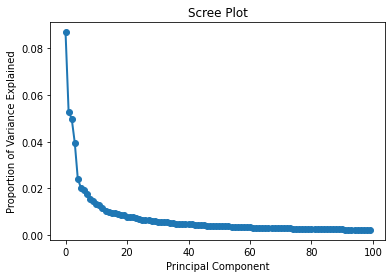

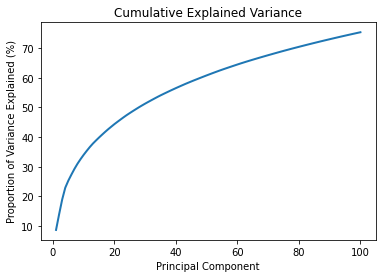

In [28]:
# set up list of explained variance by component
ex_var_list = []
ex_var_cum = 0
for v in pca.explained_variance_ratio_:
    ex_var_cum = ex_var_cum + (v*100)
    ex_var_list.append(ex_var_cum)

# create the traditional scree plot
PC_values = np.arange(100)
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

# create a cumulative variance plot
PC_values = np.arange(100) + 1
plt.plot(PC_values, ex_var_list, '-', linewidth=2)
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained (%)')
plt.show()

The scree plot shows a distinct drop-off after the first 10 components. 74 components is well into the flattening of the slope and is sufficient. The cumulative plot at 74 components shows just about 70% of variance explained.

The 74 component PCA can now be applied to the population and customer datasets.

In [29]:
pca = PCA(74).fit(scaled_azdias)
reduced_azdias = pca.transform(scaled_azdias)
reduced_customers = pca.transform(scaled_customers)

### K-Means Clustering

The next step of the segmentation analysis is to apply a classification algorithm to the reduced data. The k-means is a good method to use to divide the population into similar segments based on the components created in the previous step.

Similar to PCA, there is no set rule for deciding how many clusters to use. A visual approach can be used to see when the effectiveness of adding additional clusters is reduced similar to the Skree plot used for PCA. For k-means the measurement is distance between clusters rather than explained variance. Again though it's desireable to reduce this value.

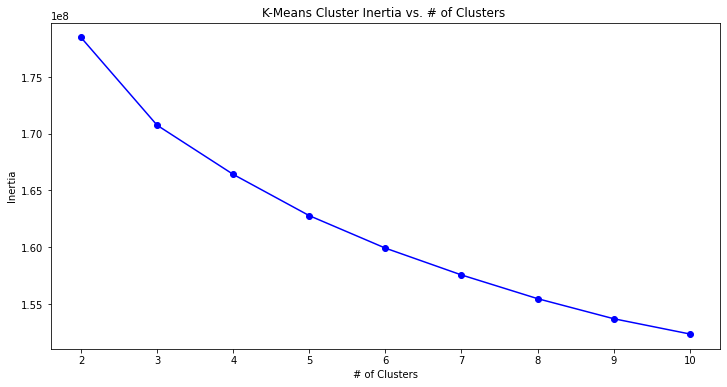

In [30]:
def kmeans_evaluation(data, max_clusters, plot=True):
    '''
    Parameters
    ----------
    data : DataFrame
        Data to construct clusters from.
    max_clusters : INT
        Maximum number of clusters to evaluate
    plot : BOOL (True)
        Produce inertia plot.

    Returns
    -------
    None
        Produces plot of k-means score over cluster amount.
    '''
    inertia = []
    range_ = range(2, max_clusters+1)
    
    for n in range_:
        kmeans = KMeans(n_clusters=n, init='k-means++')
        model = kmeans.fit(data)
        inertia.append(model.inertia_)
        
    if plot:
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111)
        ax.plot(range_, inertia, linestyle= "-",marker = "o", color="blue")
        ax.set_xlabel("# of Clusters")
        ax.set_ylabel("Inertia")
        ax.set_title("K-Means Cluster Inertia vs. # of Clusters ")
        plt.show()
    return

kmeans_evaluation(reduced_azdias, 10, True)

The visualization of the scores shows distinct improvements as the number of clusters increase. At about 10 clusters, the slope appears to stop changing and holds constant, although still decreases as clusters are added. We'll use 8 clusters for this analysis.

The next step is to re-run the k-means clustering but only with the selected number of clusters. The model will be fit to the population data so create the clusters, then applied to both the population and customer data to classify each person into a cluster.

In [31]:
# fit initial model to population data
kmeans = KMeans(n_clusters=8, init='k-means++')
model = kmeans.fit(reduced_azdias)

# apply fitted model to population and customer data
azdias_clusters = model.predict(reduced_azdias)
customer_clusters = model.predict(reduced_customers)

customers_clusters = pd.Series(customer_clusters)
azdias_clusters = pd.Series(azdias_clusters)

The goal is to compare the composition of the general population vs. customers to see how customers are different. The clusters can provide this information by showing how each dataset is represented by the clusters. The below chart plots the makeup of the population and customer data by cluster, showing what proportion of the data each cluster accounts for.

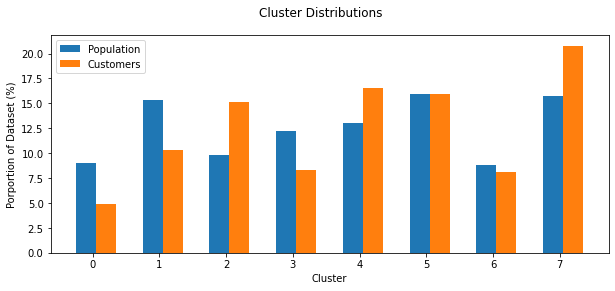

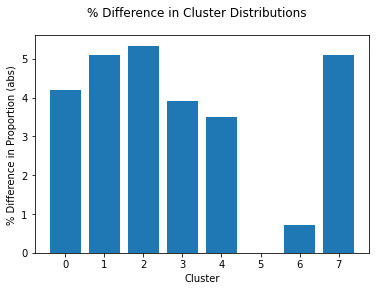

In [32]:
# Compare % of representation in each cluster
cluster_info = pd.DataFrame([])

cluster_info["Population"] = (azdias_clusters.value_counts().sort_index()/len(azdias_clusters))
cluster_info["Customers"] = (customers_clusters.value_counts().sort_index()/len(customers_clusters))
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

fig, ax1 = plt.subplots(figsize=(10, 4))

azdias = ax1.bar(cluster_info["Cluster"]-0.1, (cluster_info["Population"]*100), 0.3)

ax1.set_xlabel("Cluster")
ax1.set_ylabel("Porportion of Dataset (%)")
ax1.set_xticks(cluster_info["Cluster"])

customer = ax1.bar(cluster_info["Cluster"]+0.2, (cluster_info["Customers"]*100), 0.3)

ax1.legend((azdias[0], customer[0]), ('Population', 'Customers'))

fig.suptitle("Cluster Distributions")
plt.show()

fig, ax1 = plt.subplots()
fig.suptitle("% Difference in Cluster Distributions")
ax1.bar(cluster_info.index.astype(str), abs((cluster_info['Population'] - cluster_info['Customers'])*100))
ax1.set_xlabel('Cluster')
ax1.set_ylabel('% Difference in Proportion (abs)')
plt.show()

Now the datasets can be easily compared using their cluster makeup. A few notable differences stand out:

Customers:
- Higher representation of clusters: 2, 7
- Lower representation of clusters: 0, 1

The data shows that customers are more likely to be people who are classified in clusters 2 and 7, and less likely to include people who are classified in clusters 0 and 1. This information is useful, but it's necesary to go a step further and determine which features make up those clusters.

### Feature Importance

Now that differences in clusters are identified, the next step is to examine which components and features contribute to those clusters. One way to do this is to find the position of the cluster's center within each component. Higher absolute distance suggests a higher effect of that component on the cluster's position.

The below function retrieves the cluster positions for each component and plots the values for the top 6 components by absolute value. We'll run this for clusters 0, 1, 2, and 7 since they are most interest to the analysis.

Cluster 0 Top 6 Component Makeup:
2   -5.808035
0   -4.213734
4    3.418473
3    2.006206
1    1.892949
9    1.213789
dtype: float64


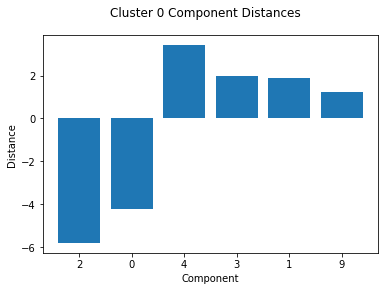

Cluster 1 Top 6 Component Makeup:
3   -5.160318
0   -0.715778
6    0.488722
1   -0.454479
4    0.361691
8    0.337193
dtype: float64


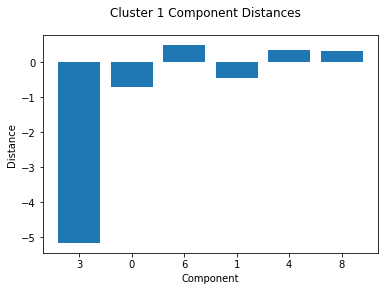

Cluster 2 Top 6 Component Makeup:
2    5.570501
1   -3.986289
0    1.926625
3    1.632791
4    1.285954
6    0.746355
dtype: float64


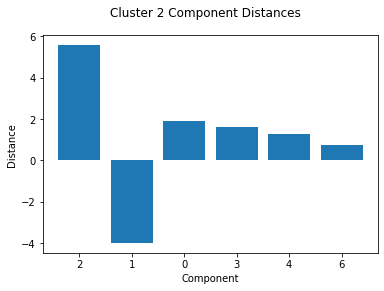

Cluster 7 Top 6 Component Makeup:
1   -4.113127
0    3.614815
2   -2.932893
4   -0.530231
9   -0.447552
6   -0.423202
dtype: float64


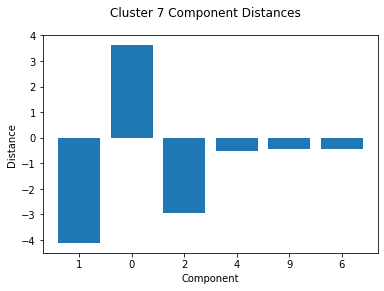

In [33]:
def cluster_components(model, cluster):
    '''
    Parameters
    ----------
    model : KMeans()
        Fitted KMeans model.
    cluster : INT
        Selected cluster to produce component plot

    Returns
    -------
    coords.index : Index
        Index of component coordinate series.
    '''
    centers=model.__dict__
    abs_vals = pd.Series(abs(centers['cluster_centers_'][cluster])).sort_values(ascending=False)[0:6]
    coords = pd.Series(centers['cluster_centers_'][cluster][abs_vals.index], index=abs_vals.index)
    print('Cluster',cluster,'Top 6 Component Makeup:')
    print(coords)
    
    fig, ax1 = plt.subplots()
    fig.suptitle(str('Cluster '+str(cluster)+' Component Distances'))
    ax1.bar(coords.index.astype(str), coords)
    ax1.set_xlabel('Component')
    ax1.set_ylabel('Distance')
    plt.show()
        
    return list(coords.index)

components_0 = cluster_components(model, 0)
components_1 = cluster_components(model, 1)
components_2 = cluster_components(model, 2)
components_7 = cluster_components(model, 7)

Examining the plots reveals common components across the clusters. Specifically we'll be interested in examining components 0, 1, 2 and 3.

A detailed breakdown:

Cluster 0:
 - 2, Negative
 - 0, Negative
 
Cluster 1:
 - 3, Negative
 
Cluster 2:
 - 2, Positive
 - 1, Negative
 
Cluster 7:
 - 1, Negative
 - 0, Positive
 
We can use a similar approach as above to find the important features by looking at each component and examining which features affect that component's value and in which direction. This will tell use about the types of people in those clusters based on the original features.

The below function finds the top 3 contributing features for the desired PCA component, along with the feature's name and description as provided in the attribute file.

In [34]:
def feature_importance(pca, component):
    '''
    Parameters
    ----------
    pca : PCA()
        Fitted PCA model.
    component : INT
        Selected component to find top 3 important features

    Returns
    -------
    None
        Displays top 3 features by importance.
    '''
    feature_importance = pd.DataFrame(pca.components_.T, index=azdias_segmentation.columns)
    feature_importance = feature_importance.merge(attributes_df, how='left', left_on = feature_importance.index, right_on='Attribute').set_index(feature_importance.index)
    feature_importance = feature_importance[[component,'Description']]
    top_3_features = feature_importance.sort_values(by=component, key=abs, ascending=False)[0:3]
    print('\nComponent ', component, ' Top 3 Contributing Features:')
    display(top_3_features)
    return

feature_importance(pca, 0)
feature_importance(pca, 1)
feature_importance(pca, 2)
feature_importance(pca, 3)


Component  0  Top 3 Contributing Features:


,0,Description
MOBI_REGIO,0.135593,moving patterns
PLZ8_ANTG1,0.128196,number of 1-2 family houses in the PLZ8
KBA13_ANTG1,0.127586,NaN



Component  1  Top 3 Contributing Features:


,1,Description
ONLINE_AFFINITAET,0.150488,online affinity
D19_GESAMT_ANZ_24,0.143997,NaN
D19_GESAMT_ONLINE_DATUM,-0.139202,actuality of the last transaction with the complete file ONLINE



Component  2  Top 3 Contributing Features:


,2,Description
KBA13_HERST_BMW_BENZ,0.176954,share of BMW & Mercedes Benz within the PLZ8
KBA13_SEG_OBEREMITTELKLASSE,0.153170,"share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)"
KBA13_MERCEDES,0.150750,share of MERCEDES within the PLZ8



Component  3  Top 3 Contributing Features:


,3,Description
FINANZ_SPARER,-0.158255,financial typology: money saver
FINANZ_ANLEGER,-0.155656,financial typology: investor
PRAEGENDE_JUGENDJAHRE,-0.154939,dominating movement in the person's youth (avantgarde or mainstream)


<b>Component 0:</b>
Primarily driven by the `MOBI_REGIO` feature which is a measure of the respondent's moving patterns, with higher values meaning less mobility. The `PLZ8_ANTG1` feature is a measure of the number of 1-2 family houses in the PLZ8 of the respondent, with higher values signifying a higher share of 1-2 family houses.

<b>Component 1:</b>
Driven by `ONLINE_AFFINITAET`, a measure of online affinity. `D19_GESAMT_ONLINE_DATUM` is a measure of recency of online activity with lower being more recent.

<b>Component 2:</b>
Made up of features measuring the share of high-end cars in the area of the respondent, with higher values meaning higher share.

<b>Component 3:</b>
Contains features related to financial habits such as money saving and investments. Lower values indicate higher propensity to exhibit these financial habits (i.e. higher value in `FINANZ_SPARER` indicates a 'saver' respondent, lower value indicates a 'spender' respondent). `PRAEGENDE_JUGENDJAHRE` is an indicator of the dominant social movement for the respondent based on their age. Lower values indicate older social movements such as the aftermath of WW2. Higher values include 1990's social movements such as a focus on technology and ecology.

### Cluster Interpretation

Now that we know which components affect the clusters, and which features contribute to those components, we can bring the interpretation back out to the clusters.

<b>Cluster 0:</b>
Low on components 2 and 0. This indicates low mobility patterns and more likely to have 1-2 family homes in their area. Also less likely to have luxury cars in their area. Customers are less likely to be from this group.

<b>Cluster 1:</b>
Low values for component 3 which indicates these respondents are more likely to have money saver / investor financial habits. Also are more likely to be affected by older social movements. This could also imply this group is higher in age range. This group overall is less likely to be customers.

<b>Cluster 2:</b>
High in component 2 which relates to popularity of luxury cars in their area. Also low on component 1, online affinity. These respondents are more likely to be customers than the general population.

<b>Cluster 7:</b>
Low values for component 1 indicate low online affinity and recency of online activity. These customers are not likely to interact online much with businesses. They are also high on component 0 which indicates low frequency of movement and high share of 1-2 family homes. These respondents are less likely to move from their current residence and likely own their own home vs. residing in a shared building like an apartment complex or condominium. Respondents in this cluster are more likely to be customers than not.


### Recommendations

Overall, it appears that customers are more likely to be individuals from the general population who meet the following critera:
- More likely to spend vs. save or invest money
- Likely in upper middle class, may enjoy showing their financial status with luxury vehicles
- Live in / own their own home vs. a shared home and do not move residences often
- Are not often online or do not rely on online interactions
- May possibly be older or influenced by older social movements

This information is valuable to Arvato and will help the business determine where to focus their advertising efforts to recruit new customers. Using segmentation, Arvato can apply this analysis to individual respondents to predict which cluster they would fall in. From there, those individuals can be further targeted (or ignored) with high confidence of successful acquisition (or reduction of lost time / resources chasing unlikely customers).

## Part 2: Supervised Learning Model

<i>Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.</i>

The final portion of this analysis is a supervised learning model that will attempt to predict a customer's response to a mailout campaign. The dataset for this portion is separate from the previous customer dataset. The first step will be to import and clean the data.

### Data Import

In [36]:
# import training data
mailout_train = pd.read_csv('mailout_train.csv', sep=',')

# check structure of dataframe
print('Training dataset:')
print(mailout_train.shape)
display(mailout_train.head())

Training dataset:
(42962, 367)


C:\Users\arshl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


The dataset matches the shape of the original customer dataset, including the warning for columns 18, 19. Therefore it's possible to use the previously constructed functions to clean the data. We'll apply the functions to correct double possible unknown values, standardize unknown values to 'nan', and clean columns 18 and 19.

In [37]:
mailout_train_clean = correct_double_values(mailout_train)
mailout_train_clean = standardize_unknowns(mailout_train_clean)
mailout_train_clean = clean_col_1819(mailout_train_clean)
mailout_train_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1.0,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1.0,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2.0,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2.0,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


Next is to handle any missing values. The previous thresholds can be used here again along with the initial functions constructed earlier to remove applicable columns and rows. Remaining missing values are imputed.

In [38]:
mailout_train_clean = drop_missing_by_column(mailout_train_clean, 0.30)
mailout_train_clean = remove_missing_rows(mailout_train_clean, 50)
mailout_train_clean = impute_missing_values(mailout_train_clean)

Dropping columns:  ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


As before, clean up any remaining object columns and drop the extra 'LNR' column it's not needed for the model.

In [39]:
get_object_columns(mailout_train_clean)
mailout_train_clean = clean_object_columns(mailout_train_clean)
mailout_train_clean = mailout_train_clean.drop('LNR', axis=1)


 5  object columns found.
CAMEO_DEU_2015
['5D' '5B' '2D' '7B' '4C' '5C' '3D' '5A' '2C' '4A' '6B' '1A' '8D' '4B'
 '7A' '4E' '3A' '7C' '9D' '8A' '5E' '8B' '3C' '6E' '4D' '2B' '3B' '7E'
 '2A' '6C' '1C' '6D' '7D' '1D' '8C' '9A' '9B' '9C' '9E' '6F' '1E' '6A'
 '5F' '1B' 'XX']
CAMEO_DEUG_2015
[5.0 2.0 7.0 4.0 3.0 6.0 1.0 8.0 9.0 '4' '6' '2' '9' '8' '7' '3' '1' '5']
D19_LETZTER_KAUF_BRANCHE
['D19_UNBEKANNT' 'D19_TELKO_MOBILE' 'D19_LEBENSMITTEL'
 'D19_BEKLEIDUNG_GEH' 'D19_BUCH_CD' 'D19_NAHRUNGSERGAENZUNG' 'D19_SCHUHE'
 'D19_SONSTIGE' 'D19_HAUS_DEKO' 'D19_FREIZEIT' 'D19_ENERGIE'
 'D19_VOLLSORTIMENT' 'D19_BANKEN_REST' 'D19_VERSICHERUNGEN'
 'D19_KINDERARTIKEL' 'D19_TECHNIK' 'D19_DROGERIEARTIKEL'
 'D19_BEKLEIDUNG_REST' 'D19_WEIN_FEINKOST' 'D19_HANDWERK' 'D19_GARTEN'
 'D19_BANKEN_DIREKT' 'D19_DIGIT_SERV' 'D19_SAMMELARTIKEL'
 'D19_BANKEN_GROSS' 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_REISEN'
 'D19_BILDUNG' 'D19_BANKEN_LOKAL' 'D19_TIERARTIKEL' 'D19_BIO_OEKO'
 'D19_RATGEBER' 'D19_LOTTO' 'D19_KOSMETIK

### Model Development

To develop the supervised learning model we'll begin by splitting the `mailout_train_clean` dataset in training and test sets. The test set consists only of the 'RESPONSE' column, containing a 1 for response, or 0 for non-response.

In [40]:
# split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(mailout_train_clean.drop('RESPONSE', axis=1),
                                                    mailout_train_clean['RESPONSE'], test_size=0.2)

In [41]:
# scale data
scaler = StandardScaler().fit(X_train)
X_train_scale = scaler.transform(X_train)

PCA will be applied to the training dataset to reduce the number of features used in the model. Since this dataset is not dependent on the population dataset, it will be fitted with its own PCA reduction. PCA will run with 100 features initially, then retain only those features that have eigenvalues >= 1.

In [42]:
# start with 100 components
pca = PCA(100)
X_train_pca = pca.fit_transform(X_train_scale)

# identify how many components have values >= 1
pca.explained_variance_
print(len(pca.explained_variance_[pca.explained_variance_>=1]), 'components have values >= 1.')

78 components have values >= 1.


Pipelines will be used to construct the models. Since it's not clear if PCA will improve the results, the chosen models will be run with and without PCA. The chosen algorithims include `LogisticRegression`, `RandomForestClassifier`, and `DecisionTreeClassifier`. The pipeline steps include scaling.

In [43]:
# construct pipelines with scaler, pca, and estimator
pipe_lr = Pipeline([('scl', StandardScaler()),('clf', LogisticRegression(max_iter=200, random_state=25))])
pipe_rf = Pipeline([('scl', StandardScaler()),('clf', RandomForestClassifier(random_state=25))])
pipe_dt = Pipeline([('scl', StandardScaler()),('clf', DecisionTreeClassifier(random_state=25))])
pipe_lr_pca = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=78)),('clf', LogisticRegression(max_iter=200,random_state=25))])
pipe_rf_pca = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=78)),('clf', RandomForestClassifier(random_state=25))])
pipe_dt_pca = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=78)),('clf', DecisionTreeClassifier(random_state=25))])

pipelines = [pipe_lr, pipe_rf, pipe_dt, pipe_lr_pca, pipe_rf_pca, pipe_dt_pca]

A function will be used to apply to pipelines and return the roc scores and data to plot the ROC curves. The function takes in the pipeline, training and test sets, then fits the pipeline and predicts the probabilities for the test set.

In [44]:
def train_pipelines(model, X_train, y_train, X_test, y_test):
    '''
    Parameters
    ----------
    model : Pipeline()
        Model pipeline to apply.
    X_train : Array
        Array of input training data.
    y_train : Array
        Array of response training data.
    X_test : Array
        Array of input test data.
    y_test : Array
        Array of response test data.

    Returns
    -------
    roc_score : FLOAT
        ROC score for model.
    x : Array
        Array of false positive rate for ROC plot
    y : Array
        Array of true positive rate for ROC plot
    '''
    model = model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)    
    roc_score = roc_auc_score(y_test, y_pred[:,1])
    x, y, _ = roc_curve(y_test, y_pred[:,1])

    print('\n',model)
    print(round(roc_score,3))
    
    fig, ax1 = plt.subplots()
    plt.plot(x, y, color='darkorange', label='ROC curve (area = %0.2f)')
    fig.suptitle('ROC Curve')
    ax1.set_xlabel('False Positive')
    ax1.set_ylabel('True Positive')
    plt.show()

    return roc_score, x, y


 Pipeline(steps=[('scl', StandardScaler()),
                ('clf', LogisticRegression(max_iter=200, random_state=25))])
0.669


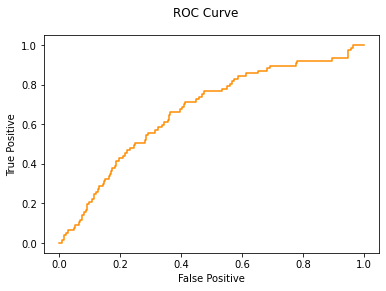


 Pipeline(steps=[('scl', StandardScaler()),
                ('clf', RandomForestClassifier(random_state=25))])
0.616


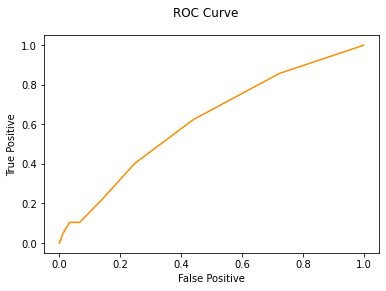


 Pipeline(steps=[('scl', StandardScaler()),
                ('clf', DecisionTreeClassifier(random_state=25))])
0.531


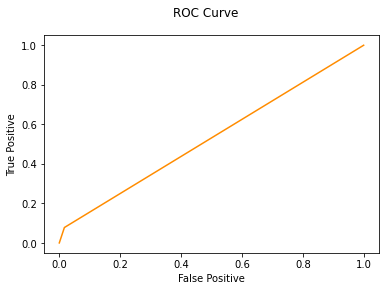


 Pipeline(steps=[('scl', StandardScaler()), ('pca', PCA(n_components=78)),
                ('clf', LogisticRegression(max_iter=200, random_state=25))])
0.614


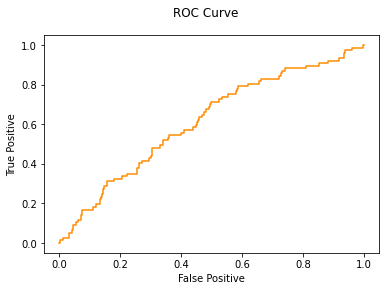


 Pipeline(steps=[('scl', StandardScaler()), ('pca', PCA(n_components=78)),
                ('clf', RandomForestClassifier(random_state=25))])
0.488


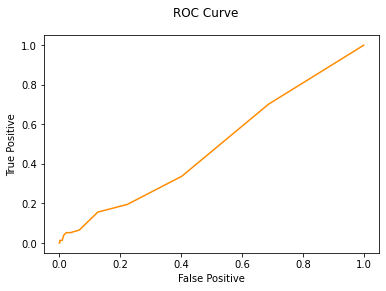


 Pipeline(steps=[('scl', StandardScaler()), ('pca', PCA(n_components=78)),
                ('clf', DecisionTreeClassifier(random_state=25))])
0.512


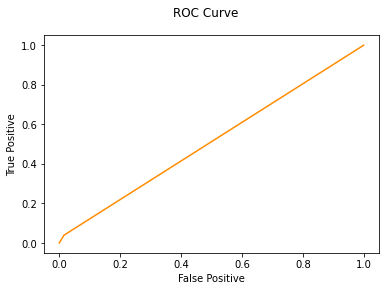

In [45]:
# run model function for each pipeline and collect info and ROC results
model_results = []
for pipe in pipelines:
    score, x, y = train_pipelines(pipe, X_train, y_train, X_test, y_test)
    model_results.append((pipe,score,x,y))

Examining the results, the first pipeline using the `LogisticRegression` algorithm achieved the highest AUC score at 0.669. The `LogisticRegression` pipeline containing the PCA reduction only achieved 0.614, indicating an application of PCA did not improve the model results. We'll retain this model to optimize and apply to the test data in the final portion of the analysis.

### Model Optimization

The model may be able to be improved further using an optimization technique such as `GridSearchCV`. The grid search will test different combinations of model parameters to select the best possible result. Since we are using the `LogisticRegression` estimator, the parameters to test are `penalty`, `class_weight`, and `max_iter`.

In [55]:
# set estimator and parameter grid
estimator = LogisticRegression(random_state=25)
parameters = {'penalty':('l1','l2'), 'solver':['liblinear'], 'class_weight':('balanced',None), 'max_iter':(200,300)}

# construct pipeline with GridSearchCV
pipe_lr_cv = Pipeline([('scl', StandardScaler()),('clf', GridSearchCV(estimator, parameters))])
cv_model = pipe_lr_cv.fit(X_train, y_train)

In [69]:
# predict values using the GridSearch pipeline
y_pred = cv_model.predict_proba(X_test)

In [70]:
# record roc score and curve data
roc_score = roc_auc_score(y_test, y_pred[:,1])
x, y, _ = roc_curve(y_test, y_pred[:,1])

In [58]:
roc_score

0.6750937002020547

In [59]:
pipe_lr_cv.steps[1][1].best_params_

{'class_weight': None, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}

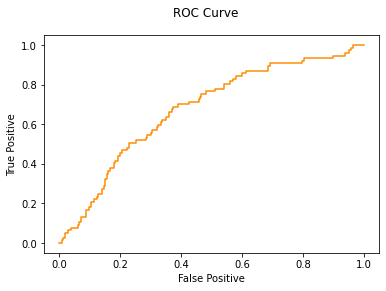

In [60]:
fig, ax1 = plt.subplots()
plt.plot(x, y, color='darkorange', label='ROC curve (area = %0.2f)')
fig.suptitle('ROC Curve')
ax1.set_xlabel('False Positive')
ax1.set_ylabel('True Positive')
plt.show()

Optimizing the `LogisticRegression` model using `GridSearchCV` resulted in a score of 0.675, a slight improvement over the original model. This was achieved with the combination of parameters:

- class_weight: None
- max_iter: 200
- penalty: l1
- solver: liblinear

The optimized model will be the one applied to the next portion of the analysis for the Kaggle competition submission.

## Part 3: Kaggle Competition

<i>Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.</i>

This portion of the analysis will follow the same steps as above, but for the `mailout_test` dataset. This dataset is similar to the `mailout_train` dataset, but does not include the 'RESPONSE' column. The goal of this portion is to apply the model selected from above to predict each customer's response to the mailout campaign. The predicted responses will be submitted for evaluation via Kaggle.

In [62]:
# import training data
mailout_test = pd.read_csv('mailout_test.csv', sep=',')

# check structure of dataframe
print('Training dataset:')
print(mailout_test.shape)
display(mailout_test.head())

Training dataset:
(42833, 366)


C:\Users\arshl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [63]:
# clean dataset unknown values & columns 18,19

mailout_test_clean = correct_double_values(mailout_test)
mailout_test_clean = standardize_unknowns(mailout_test_clean)
mailout_test_clean = clean_col_1819(mailout_test_clean)
mailout_test_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2.0,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2.0,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,NaN,7.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1.0,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [64]:
# remove columns with >= 30% missing values
# note: rows cannot be removed as all respondents need to be present in the submitted data
mailout_test_clean = drop_missing_by_column(mailout_test_clean, 0.30)

Dropping columns:  ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


In [65]:
# impute remaining missing values & get remaining object columns
mailout_test_clean = impute_missing_values(mailout_test_clean)
get_object_columns(mailout_test_clean)


 5  object columns found.
CAMEO_DEU_2015
['2B' '5A' '7A' '9D' '4E' '6B' '2D' '1D' '7E' '4C' '1C' '4A' '5F' '6D'
 '3C' '9B' '6C' '8B' '3D' '5D' '1A' '3A' '7B' '2C' '8A' '6F' '2A' '5B'
 '6E' '5C' '8D' '4D' '8C' '9E' '7C' '9A' '6A' '9C' '1B' '3B' '7D' '1E'
 'XX' '4B' '5E']
CAMEO_DEUG_2015
['2' '5' '7' '9' '4' '6' '1' 6.0 '3' '8' 3.0 4.0 8.0 2.0 5.0 7.0 9.0 1.0]
D19_LETZTER_KAUF_BRANCHE
['D19_BEKLEIDUNG_GEH' 'D19_UNBEKANNT' 'D19_LEBENSMITTEL'
 'D19_BANKEN_GROSS' 'D19_SONSTIGE' 'D19_HAUS_DEKO' 'D19_VERSICHERUNGEN'
 'D19_BUCH_CD' 'D19_VERSAND_REST' 'D19_BEKLEIDUNG_REST'
 'D19_VOLLSORTIMENT' 'D19_ENERGIE' 'D19_DROGERIEARTIKEL'
 'D19_WEIN_FEINKOST' 'D19_TELKO_MOBILE' 'D19_HANDWERK' 'D19_TELKO_REST'
 'D19_LOTTO' 'D19_BANKEN_DIREKT' 'D19_SCHUHE' 'D19_TECHNIK' 'D19_BILDUNG'
 'D19_RATGEBER' 'D19_DIGIT_SERV' 'D19_NAHRUNGSERGAENZUNG' 'D19_GARTEN'
 'D19_BIO_OEKO' 'D19_SAMMELARTIKEL' 'D19_FREIZEIT' 'D19_BANKEN_LOKAL'
 'D19_KINDERARTIKEL' 'D19_TIERARTIKEL' 'D19_BANKEN_REST' 'D19_REISEN'
 'D19_KOSMETIK

In [66]:
# clean object columns and remove 'LNR' column for predictions
mailout_test_clean = clean_object_columns(mailout_test_clean)
mailout_test_clean = mailout_test_clean.drop('LNR', axis=1)

In [78]:
# scale data using the training data scaler
mailout_test_scale = scaler.transform(mailout_test_clean)

In [79]:
# apply model & predict responses
results_array = cv_model.predict_proba(mailout_test_scale)[:,1]

In [80]:
# attach response predictions to original dataset as new column
mailout_test['RESPONSE'] = results_array.tolist()

In [81]:
# submission data only needs 'LNR' and 'RESPONSE' columns
kaggle_data = mailout_test[['LNR','RESPONSE']]
kaggle_data.head()

,LNR,RESPONSE
0,1754,2.139014e-45
1,1770,3.250141e-45
2,1465,2.308839e-45
3,1470,1.173529e-45
4,1478,5.689937e-44


In [82]:
# save data to CSV
kaggle_data.to_csv('kaggle_submission.csv', index=False)

The `kaggle_submission.csv` file can now be uploaded to the Kaggle competition for evaluation.